# 0.0. IMPORTS

In [122]:
import math
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb
import pickle
import random
import warnings

from matplotlib import rcParams
from matplotlib.pyplot import GridSpec
from IPython.display import Image
from tabulate import tabulate
from scipy import stats as ss
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

## 0.1. Helper Functions

In [123]:

# Cramer'v is a measure of association between two nominal variables. Here I built a function to calculate this measure. 

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

# Since the sklearn doesn't have the mean percentage error, I built this function to calculate it. 

def mean_percentage_error( y, yhat):
    return np.mean(( y- yhat) / y)

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    return pd.DataFrame({ "Model Name": model_name,
                          "MAE": mae,
                          "MAPE": mape,
                          "RMSE": rmse }, index = [0])

# The cross_validation function splits the dataset into test and train, uses a given model, and then gives 
# the error measurements. It will be used in the model part at the end of project.


def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed (range(1,kfold + 1)):
        if verbose: 
            print("\n KFold Number: {}".format(k))

        # start and end date for validation

        validation_start_date = x_training["date"].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training["date"].max() - datetime.timedelta(days = (k-1)*6*7)

        # filtering dataset

        training = x_training[x_training["date"] < validation_start_date]
        validation = x_training[(x_training["date"] >= validation_start_date) & (x_training["date"] <= validation_end_date) ]

        # training and validation dataset
        # training 

        xtraining = training.drop(["date","sales"], axis = 1)
        ytraining = training["sales"]

        # validation
        xvalidation = validation.drop(["date","sales"], axis = 1)
        yvalidation = validation["sales"]

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat_lr = m.predict (xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat_lr))

        # store performance of each kfold iteration
        mae_list.append(m_result["MAE"])
        mape_list.append(m_result["MAPE"])
        rmse_list.append(m_result["RMSE"])

    return pd.DataFrame({"Model Name": model_name, 
                         "MAE CV": np.round(np.mean(mae_list), 2).astype(str) + " +/- " + 
                         np.round(np.std(mae_list), 2).astype(str),
                         "MAPE CV": np.round(np.mean(mape_list), 2).astype(str) + " +/- " + 
                         np.round(np.std(mape_list), 2).astype(str),
                         "RMSE CV": np.round(np.mean(rmse_list), 2).astype(str) + " +/- " +
                         np.round(np.std(rmse_list), 2).astype(str)}, 
                         index = [0])

## 0.2. Loading Data

In [124]:
df_sales_raw = pd.read_csv("data/train.csv", low_memory = False)
df_store_raw = pd.read_csv("data/store.csv", low_memory = False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how = "left", on = "Store")

# 1.0. DATA DESCRIPTION

In [125]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [126]:
# Putting a underscore before the capital letters after the beginning of the word, and leaving everything in lowercase after.

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [127]:
print("Number of Rows: {}".format(df1.shape[0]))
print("Number of Cols: {}".format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [128]:
# Transforming date column to datetime

df1["date"] = pd.to_datetime(df1["date"])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [129]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [130]:
# competition_distance
df1["competition_distance"] = df1["competition_distance"].apply(lambda x: 200000.0 if math.isnan( x ) else x)

# competition_open_since_month
# replacing the nan values with the month where the sale was made
df1["competition_open_since_month"] = df1.apply( lambda x: x["date"].month if math.isnan( x["competition_open_since_month"]) else x["competition_open_since_month"], axis = 1)

# competition_open_since_year     
# replacing the nan values with the year where the sale was made
df1["competition_open_since_year"] = df1.apply( lambda x: x["date"].year if math.isnan( x["competition_open_since_year"]) else x["competition_open_since_year"], axis = 1)
                             
# promo2_since_week 
# replacing the nan values with the week where the sale was made
df1["promo2_since_week"] = df1.apply( lambda x: x["date"].week if math.isnan( x["promo2_since_week"]) else x["promo2_since_week"], axis = 1)
                             
# promo2_since_year 
# replacing the nan values with the year where the sale was made
df1["promo2_since_year"] = df1.apply( lambda x: x["date"].year if math.isnan( x["promo2_since_year"]) else x["promo2_since_year"], axis = 1)

# promo_interval                  

df1["promo_interval"].fillna(0, inplace = True)

# Since the "promo_interval" column is with the values "jan", "feb", etc. I created the month_map to pass the same values to
# the month where the sale was made.
# Then, I applied a function to find out if, in a month, there was a promotion going on.
month_map = {1: "Jan", 2: "Feb", 3: "Mar",4: "Apr", 5: "May", 6: "Jun", 7: "Jul",8: "Aug",9: "Sept", 10: "Oct",11: "Nov", 12: "Dec"}

df1["month_map"] = df1["date"].dt.month.map(month_map)

df1["is_promo"] = df1[["promo_interval","month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split(",") else 0, axis = 1)

## 1.6. Change Types

In [131]:
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype("int64")
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype("int64")

df1["promo2_since_week"] = df1["promo2_since_week"].astype("int64")
df1["promo2_since_year"] = df1["promo2_since_year"].astype("int64")

## 1.7. Descriptive Statistics

In [132]:
numeric = list(pd.DataFrame(df1.dtypes[(df1.dtypes == 'int64') | (df1.dtypes == "float64")]).reset_index()["index"])
non_numeric = list(pd.DataFrame(df1.dtypes[(df1.dtypes != 'int64') & (df1.dtypes != "float64") &
                                          (df1.dtypes != 'datetime64[ns]')]).reset_index()["index"])
num_attributes = df1[numeric]
cat_attributes = df1[non_numeric]

## 1.7.1 Numerical Attributes

In [133]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame (num_attributes.apply(np.std)).T
d2 = pd.DataFrame (num_attributes.apply(min)).T
d3 = pd.DataFrame (num_attributes.apply(max)).T
d4 = pd.DataFrame (num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame (num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame (num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ["attributes","min","max","range","mean","median","std","skew","kurtosis"]

In [134]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2 Categorical Attributes

In [135]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

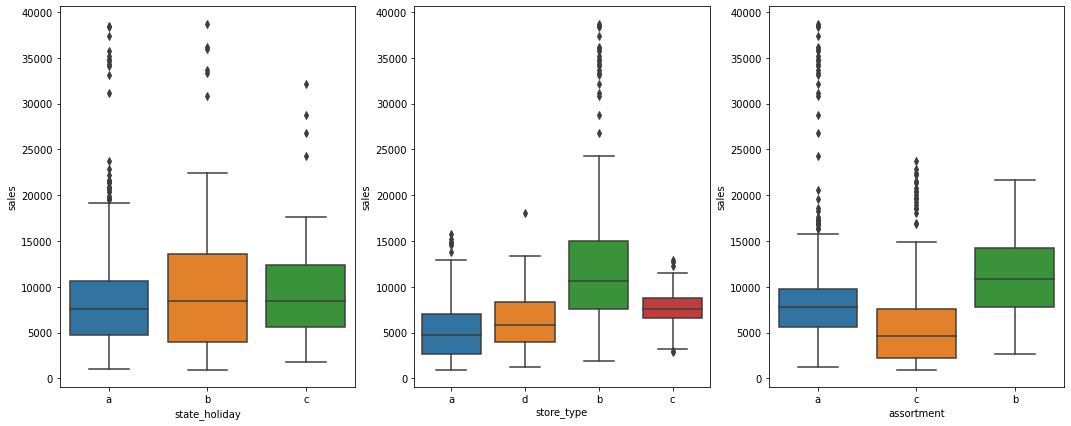

In [136]:
# Checking sales by holidays, store type and assortment

aux1 = df1[(df1["state_holiday"] != "0") & (df1["sales"] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot( x="state_holiday" , y="sales", data = aux1)

plt.subplot(1, 3, 2)
sns.boxplot( x="store_type" , y="sales", data = aux1)

plt.subplot(1, 3, 3)
sns.boxplot( x="assortment" , y="sales", data = aux1)

rcParams['figure.figsize'] = 18,7          
plt.show()

# 2.0. FEATURE ENGINEERING

## 2.1. Mind Map Hypothesis

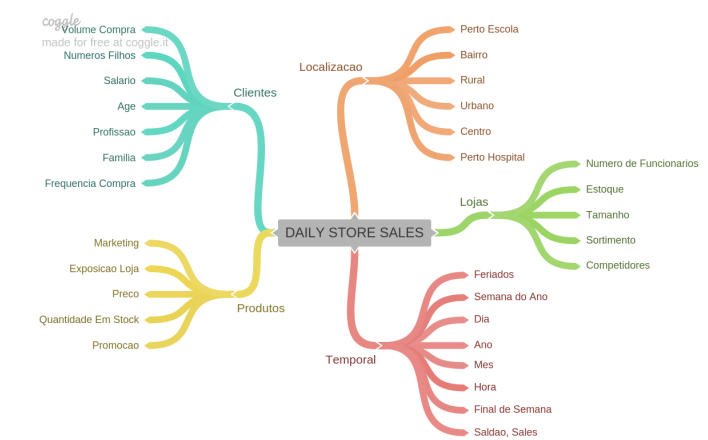

In [137]:
Image("img/mindmap.png")

## 2.1. Creating Hypothesis

### 2.1.1. Store Hypothesis

**1.** Stores with more employees should sell more.

**2.** Stores with greater inventory capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with larger assortments should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with competitors for the longest time should sell more.

### 2.1.2. Product Hypothesis

**1.** Stores that invest more in marketing should sell more.

**2.** Stores with greater product exposure should sell more.

**3.** Stores with lower priced products should sell more.

**4**. Stores with more aggressive promotions (bigger discounts) should sell more.

**5.** Stores with promotions active for a longer time should sell more.

**6.** Stores with more promotion days should sell more.

**7**. Stores with more consecutive promotions should sell more.

### 2.1.3. Periodicity Hypothesis

**1.** Stores open over the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of every month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 2.2. Final Hypothesis

**1.** Stores with larger assortments should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with promotions active for a longer time should sell more.

**5**. Stores with more consecutive promotions should sell more.

**6.** Stores open over the Christmas holiday should sell more.

**7.** Stores should sell more over the years.

**8.** Stores should sell more in the second half of the year.

**9.** Stores should sell more after the 10th of every month.

**10.** Stores should sell less on weekends.

**11.** Stores should sell less during school holidays.

## 2.3. Feature Engineering

In [138]:
df2 = df1.copy()

# taking out the year's variable from "date"
df2["year"] = df2["date"].dt.year

# taking out the month's variable from "date"
df2["month"] = df2["date"].dt.month

# taking out the day's variable from "date"
df2["day"] = df2["date"].dt.day

# creating the week of year's variable from "date"
df2["week_of_year"] = df2["date"].dt.weekofyear

# creating year of week's variable from "date"
df2["year_week"] = df2["date"].dt.strftime("%Y-%W")

# creating competition since's variable by joining "competition_open_since_year" and "competition_open_since_month"
df2["competition_since"] = df2.apply(lambda x: datetime.datetime(year = x["competition_open_since_year"], 
                                       month = x["competition_open_since_month"], day = 1), axis = 1)

# creating competition time month's variable by subtracting the "date" variable by the "competition_since" variable
df2["competition_time_month"] = ((df2["date"] - df2["competition_since"]) / 30).apply(lambda x:x.days).astype(int)

# creating promo_since's variable by combining 'promo2_since_year' and 'promo2_since_week'
df2["promo_since"] = df2["promo2_since_year"].astype(str) + "-" + df2["promo2_since_week"].astype(str)
df2["promo_since"] = df2["promo_since"].apply(lambda x: datetime.datetime.strptime( x + "-1", "%Y-%W-%w") - 
                                              datetime.timedelta( days = 7))

# creating 'promo_time_week' by calculating the difference between 'date' and 'promo_since':
df2["promo_time_week"] = ((df2["date"] - df2["promo_since"]) / 7).apply(lambda x: x.days).astype(int)

# giving assortment's variable new values based on the given classification
df2["assortment"] = df2["assortment"].apply(lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended")

# giving state holiday's variable new values based on the given classification
df2["state_holiday"] = df2["state_holiday"].apply(lambda x: "public_holiday" if x == "a" 
                                                  else "easter_holiday" if x == "b" else "christmas" 
                                                  if x == "c" else "no_holiday")

# negative values for 'promo_time_week' means that promotion happened after sales register

<ipython-input-138-28dfe063cb57>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2["week_of_year"] = df2["date"].dt.weekofyear


# 3.0. VARIABLE FILTERING

In [139]:
df3 = df2.copy()

## 3.1. Lines Filtering

In [140]:
df3 = df3[(df3["open"] !=0) & (df3["sales"] > 0)]

## 3.2. Columns Selections

In [141]:
cols_drop = ["customers","open", "promo_interval", "month_map"]
df3 = df3.drop(cols_drop, axis = 1)

# 4.0. EXPLORATORY DATA ANALYSIS

In [142]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

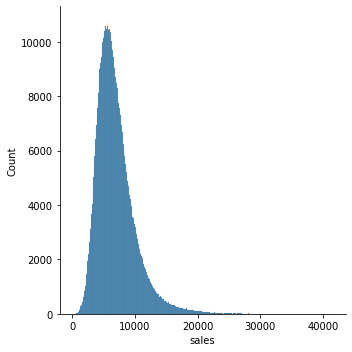

In [143]:
sns.displot(df4["sales"], kde = False)
plt.show()

### 4.1.2. Numerical Variable

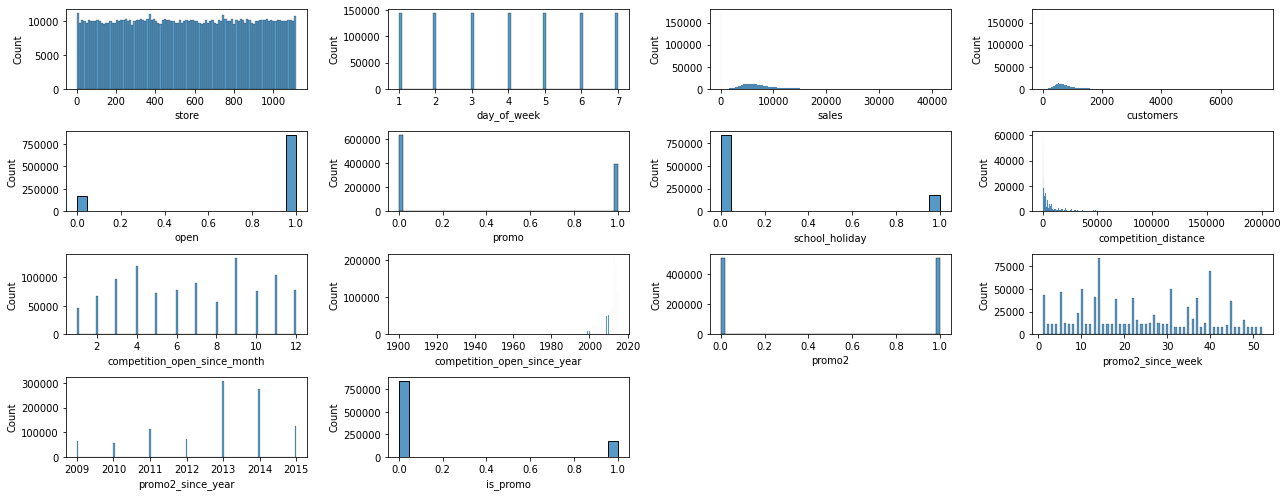

In [144]:

plt.subplot(4,4,1)
sns.histplot(data = num_attributes, x = "store");

plt.subplot(4,4,2)
sns.histplot(data = num_attributes, x = "day_of_week");

plt.subplot(4,4,3)
sns.histplot(data = num_attributes, x = "sales");

plt.subplot(4,4,4)
sns.histplot(data = num_attributes, x = "customers");

plt.subplot(4,4,5)
sns.histplot(data = num_attributes, x = "open");

plt.subplot(4,4,6)
sns.histplot(data = num_attributes, x = "promo");

plt.subplot(4,4,7)
sns.histplot(data = num_attributes, x = "school_holiday");

plt.subplot(4,4,8)
sns.histplot(data = num_attributes, x = "competition_distance");

plt.subplot(4,4,9)
sns.histplot(data = num_attributes, x = "competition_open_since_month");

plt.subplot(4,4,10)
sns.histplot(data = num_attributes, x = "competition_open_since_year");
             
plt.subplot(4,4,11)
sns.histplot(data = num_attributes, x = "promo2");

plt.subplot(4,4,12)
sns.histplot(data = num_attributes, x = "promo2_since_week");
             
plt.subplot(4,4,13)
sns.histplot(data = num_attributes, x = "promo2_since_year");
             
plt.subplot(4,4,14)
sns.histplot(data = num_attributes, x = "is_promo");



plt.tight_layout()

### 4.1.3. Categorical Variable

C:\Users\victo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\victo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\victo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


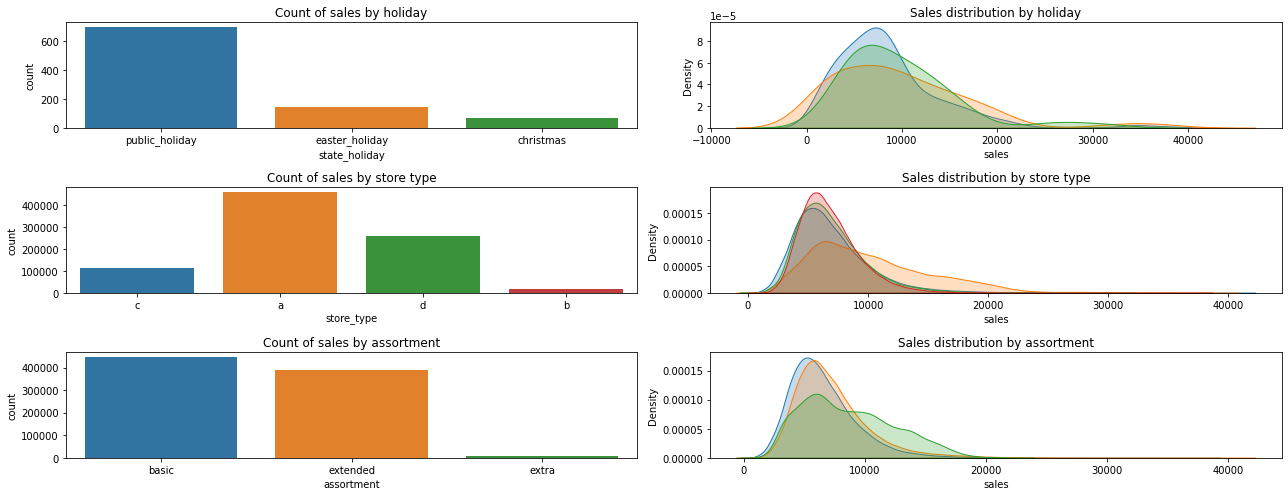

In [145]:
#state_holiday
plt.subplot(3,2,1)

a = df4[df4["state_holiday"] != "no_holiday"]
sns.countplot( a["state_holiday"]).set_title("Count of sales by holiday")

plt.subplot(3,2,2)
sns.kdeplot( df4[df4["state_holiday"] == "public_holiday"]["sales"], label = "public_holiday", shade = True)
sns.kdeplot( df4[df4["state_holiday"] == "easter_holiday"]["sales"], label = "easter_holiday", shade = True)
sns.kdeplot( df4[df4["state_holiday"] == "christmas"]["sales"], label = "christmas", shade = True).set_title("Sales distribution by holiday")

plt.subplot(3,2,3)
sns.countplot(df4["store_type"]).set_title("Count of sales by store type")

plt.subplot(3,2,4)

sns.kdeplot(df4[df4["store_type"] == "a"]["sales"], label = "a", shade = True)
sns.kdeplot(df4[df4["store_type"] == "b"]["sales"], label = "b", shade = True)
sns.kdeplot(df4[df4["store_type"] == "c"]["sales"], label = "c", shade = True)
sns.kdeplot(df4[df4["store_type"] == "d"]["sales"], label = "d", shade = True).set_title("Sales distribution by store type")

plt.subplot(3,2,5)
sns.countplot(df4["assortment"]).set_title("Count of sales by assortment")

plt.subplot(3,2,6)

sns.kdeplot(df4[df4["assortment"] == "basic"]["sales"], label = "basic", shade = True)
sns.kdeplot(df4[df4["assortment"] == "extended"]["sales"], label = "extended", shade = True)
sns.kdeplot(df4[df4["assortment"] == "extra"]["sales"], label = "extra", shade = True).set_title("Sales distribution by assortment")

plt.tight_layout()

## 4.2. Bivariate Analysis

### **H1.** Stores with larger assortments should sell more.
**True**: Stores with a larger assortment sell, on average, more than stores with a smaller one. The sale of "extra" assortment stores is following an increase behavior over time.

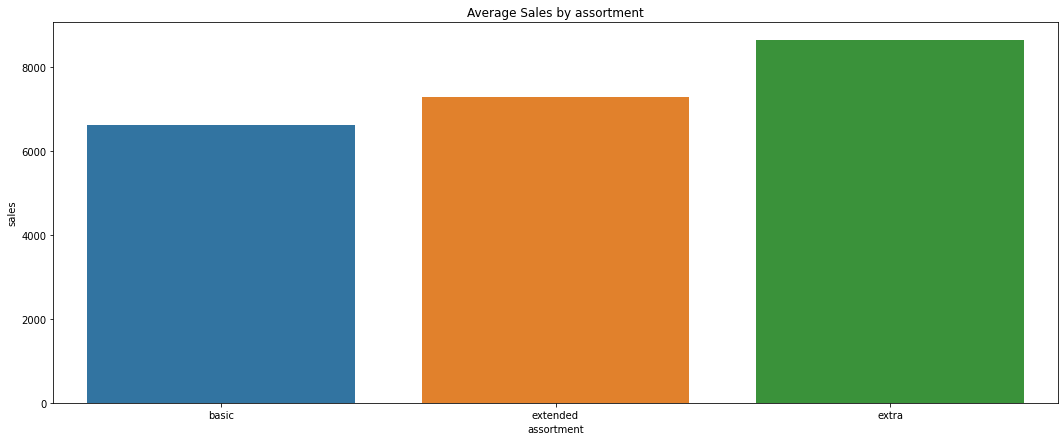

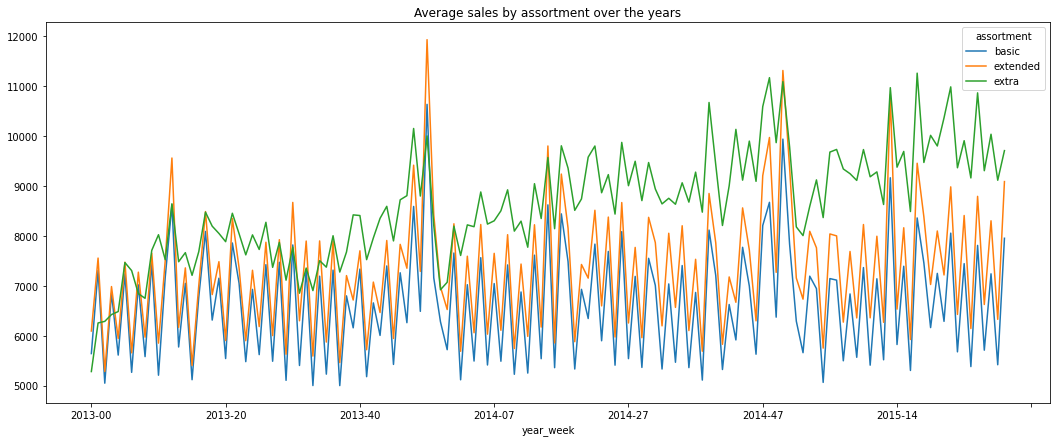

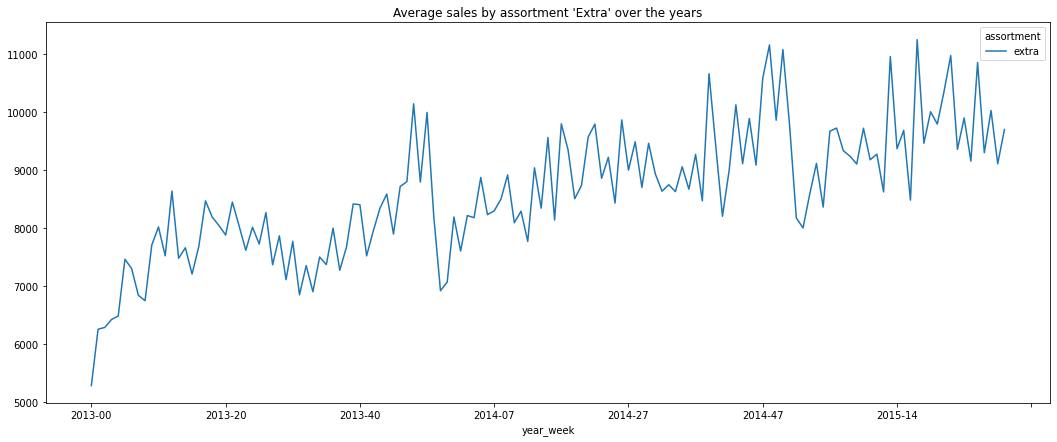

In [146]:
aux1 = df4[["assortment","sales"]].groupby("assortment").mean().reset_index()
sns.barplot(x = "assortment", y = "sales", data = aux1).set_title("Average Sales by assortment")

aux2 = df4[["year_week", "assortment","sales"]].groupby(["year_week","assortment"]).mean().reset_index()
aux2.pivot( index = "year_week", columns = "assortment", values = "sales").plot().set_title("Average sales by assortment over the years")

aux3 = aux2[aux2["assortment"] == "extra"]
aux3.pivot( index = "year_week", columns = "assortment", values = "sales").plot().set_title("Average sales by assortment 'Extra' over the years")

plt.show()

### **H2.** Stores with closer competitors should sell less.
**False:** There doesn't seem to be a correlation between the number of sales and the distance to competitors.

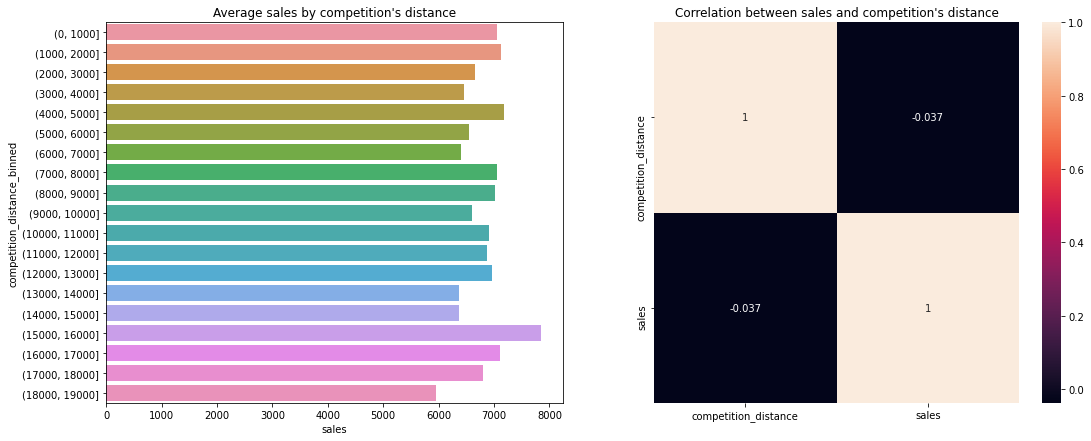

In [147]:
aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").mean().reset_index()

# regrouping data using the bins
bins = list(np.arange(0, 20000, 1000))

aux1["competition_distance_binned"] = pd.cut( aux1["competition_distance"], bins = bins)
aux2 = aux1[["competition_distance_binned", "sales"]].groupby("competition_distance_binned").mean().reset_index()

plt.subplot(1, 2, 1)
sns.barplot( y="competition_distance_binned", x = "sales", data = aux2).set_title("Average sales by competition's distance");

plt.subplot(1, 2, 2)
sns.heatmap(aux1[["competition_distance", "sales"]].corr(method = "pearson"), annot = True).set_title("Correlation between sales and competition's distance");

### **H3.** Stores with longer competitors should sell more.
**TRUE**: There appears to be a negative correlation, on average, between sales and the length of time that there's competition.

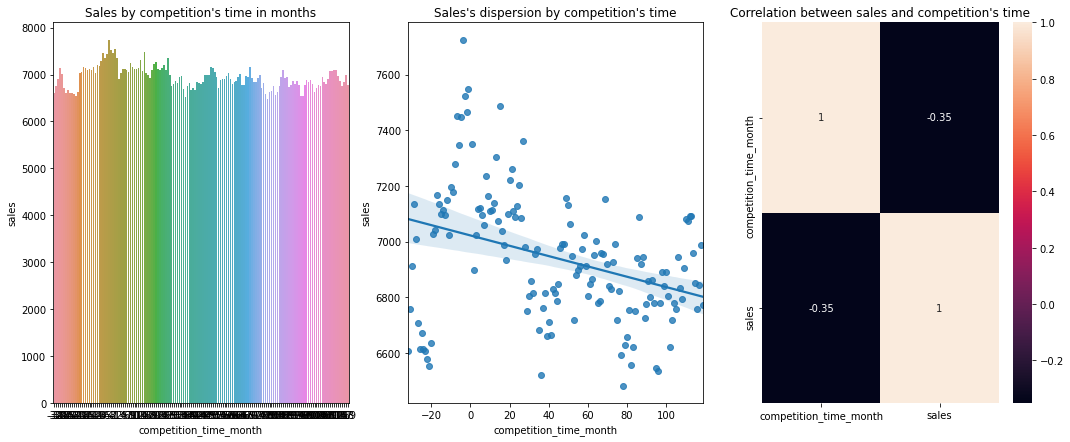

In [148]:
aux1 = df4[["competition_time_month","sales"]].groupby("competition_time_month").mean().reset_index()
aux2 = aux1[(aux1["competition_time_month"] < 120) & (aux1["competition_time_month"] != 0)]


plt.subplot(1,3,1)
sns.barplot( x = "competition_time_month", y = "sales", data = aux2).set_title("Sales by competition's time in months");

plt.subplot(1,3,2)
sns.regplot( x = "competition_time_month", y = "sales", data = aux2).set_title("Sales's dispersion by competition's time");

plt.subplot(1,3,3);
x = sns.heatmap(aux2[["competition_time_month","sales"]].corr(method = "pearson"), annot = True).set_title("Correlation between sales and competition's time");


### **H4.** Stores with promotions active for a longer period should sell more.
**TRUE**: There appears to be a positive relationship, on average, between the number of sales and the length of active promotion.

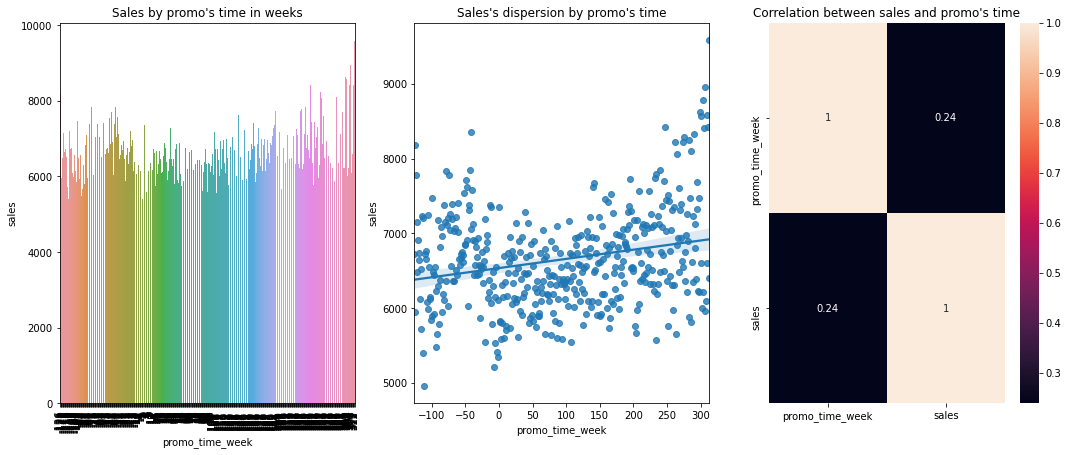

In [149]:
aux1 = df4[["promo_time_week","sales"]].groupby("promo_time_week").mean().reset_index()

plt.subplot(1,3,1)
aux2 = aux1
sns.barplot(x = "promo_time_week", y = "sales", data = aux2).set_title("Sales by promo's time in weeks");
plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x = "promo_time_week", y = "sales", data = aux2).set_title("Sales's dispersion by promo's time");

plt.subplot(1,3,3)
sns.heatmap(aux1[["promo_time_week","sales"]].corr(method = "pearson"), annot = True).set_title("Correlation between sales and promo's time");
plt.yticks(rotation = 90);


### **H5.** Stores with more consecutive promotions should sell more.
**FALSE**: Stores with more consecutive promotions sell less than those with only the original promotion.

In [150]:
df4[["promo","promo2","sales"]].groupby(["promo","promo2"]).mean().reset_index()

,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


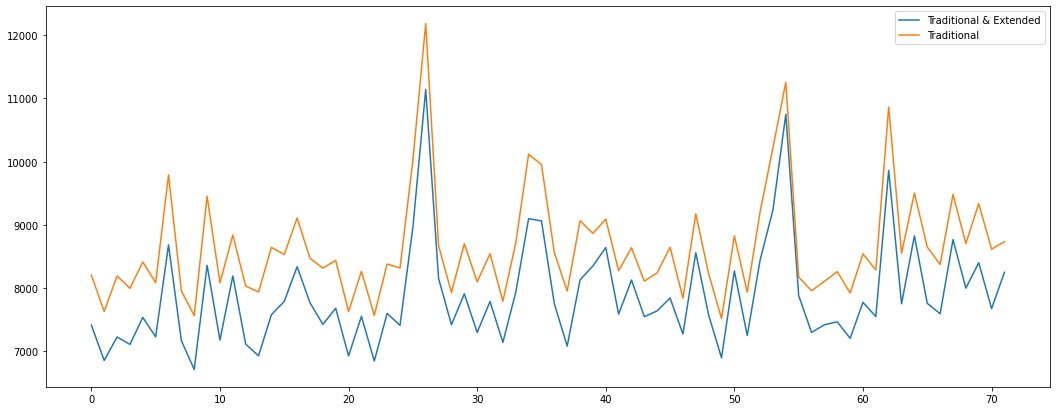

In [151]:
aux1 = df4[(df4["promo"] == 1) & (df4["promo2"] == 1)][["year_week","sales"]].groupby("year_week").mean().reset_index()
ax = aux1.plot();
aux2 = df4[(df4["promo"] == 1) & (df4["promo2"] == 0)][["year_week","sales"]].groupby("year_week").mean().reset_index()
aux2.plot(ax = ax);

ax.legend(labels = ["Traditional & Extended","Traditional"]);

### **H6.** Stores open during the Christmas holidays should sell more.
**TRUE**: The Christmas holiday on average outsells regular days (no_holiday) and public holidays "public_holiday". If we look at the year, in 2014, the Christmas holiday was the biggest seller. In 2015 there is no Christmas because the data does not arrive in that period.

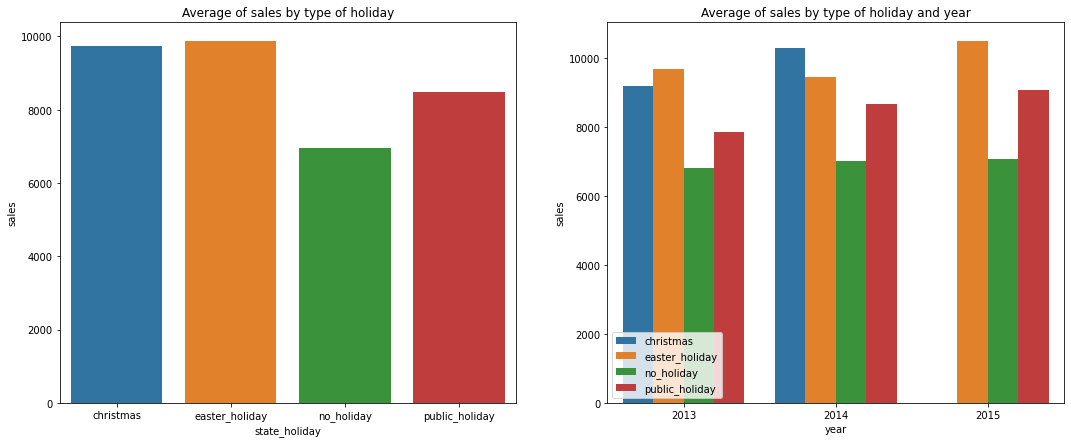

In [152]:
plt.subplot(1,2,1)
aux1 = df4[["state_holiday","sales"]].groupby("state_holiday").mean().reset_index()
sns.barplot( x = "state_holiday", y = "sales", data = aux1).set_title("Average of sales by type of holiday");

plt.subplot(1,2,2)
aux2 = df4[["year","state_holiday","sales"]].groupby(["year","state_holiday"]).mean().reset_index()
sns.barplot( x = "year", y = "sales", hue = "state_holiday", data = aux2).set_title("Average of sales by type of holiday and year");
plt.legend(loc='lower left');

### **H7.** Stores should sell more over the years.
**TRUE**: As the year 2015 only lasts until July, that is, little more than the first half of that year, I chose to restrict the dataframe, in all years, only until July to see the behavior. Apparently, there is an increase in sales volume over the years in the first 7 months.

In [153]:
df4[df4["date"].dt.year == 2015]["date"].max()

Timestamp('2015-07-31 00:00:00')

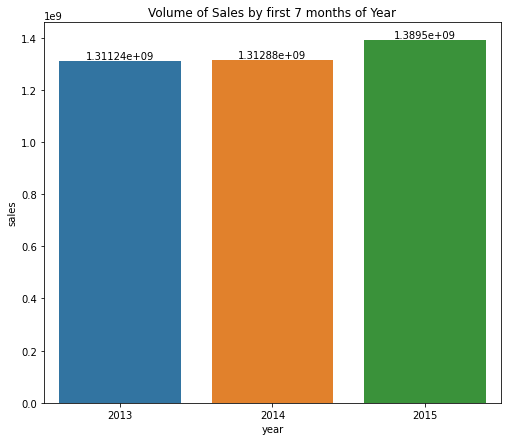

In [154]:
aux1 = df4[df4["month"] <=7]
aux2 = aux1[["year", "sales"]].groupby("year").sum().reset_index()

plt.subplot(1,2,1)
ax = sns.barplot( x = "year", y = "sales", data = aux2);

ax.bar_label(ax.containers[0]);

ax.set_title('Volume of Sales by first 7 months of Year');

### **H8.** Stores should sell more in the second half of the year.
**False**: Stores sell less in the second half.

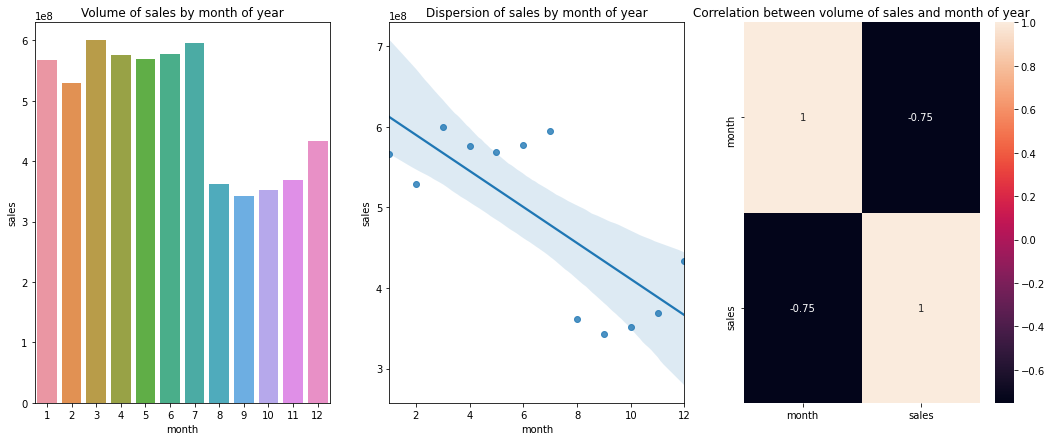

In [155]:
aux1 = df4[["month", "sales"]].groupby("month").sum().reset_index()

plt.subplot(1,3,1)
sns.barplot( x = "month", y = "sales", data = aux1).set_title('Volume of sales by month of year');

plt.subplot(1,3,2)
sns.regplot( x = "month", y = "sales", data = aux1).set_title('Dispersion of sales by month of year');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = "pearson"), annot = True).set_title('Correlation between volume of sales and month of year');

### **H9.** Stores should sell more after the 10th of each month.
**FALSE**: Stores sell more, on average, before the 10th.

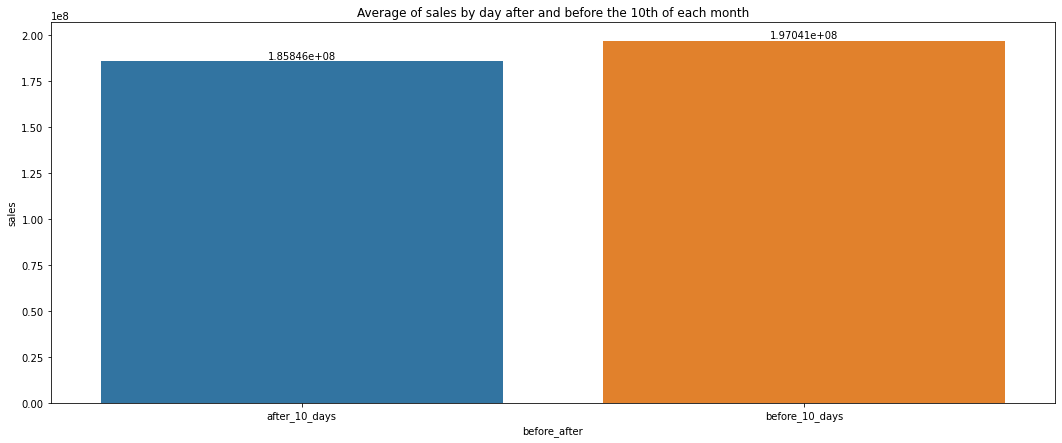

In [156]:
aux1 = df4[["day", "sales"]].groupby("day").sum().reset_index().copy()

aux1["before_after"] = aux1["day"].apply(lambda x: "before_10_days" if x <= 10 else "after_10_days")
aux2 = aux1[["before_after","sales"]].groupby("before_after").mean().reset_index()
ax = sns.barplot( x = "before_after", y = "sales", data = aux2);

ax.bar_label(ax.containers[0]);

ax.set_title("Average of sales by day after and before the 10th of each month");

### **H10.** Stores should sell less on weekends.
**TRUE**: Stores have a lower volume of sales on weekends.

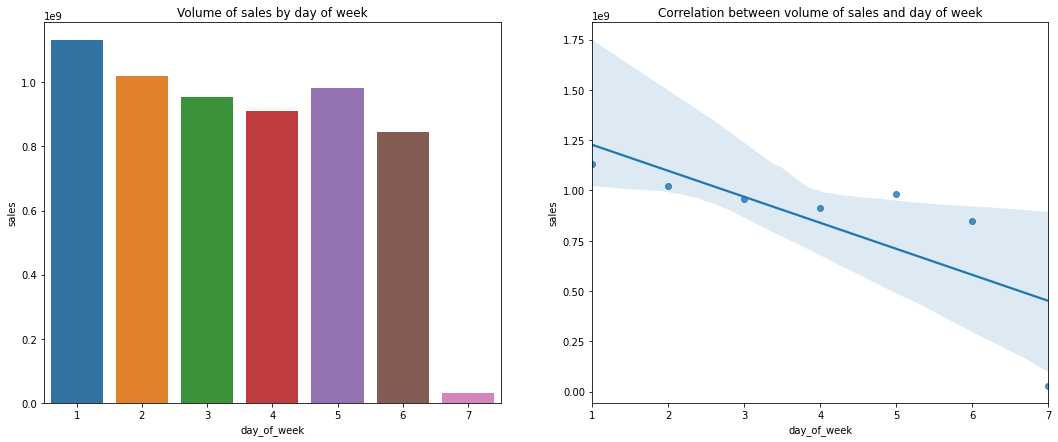

In [157]:
aux1 = df4[["day_of_week", "sales"]].groupby("day_of_week").sum().reset_index()

plt.subplot(1,2,1)
sns.barplot( x = "day_of_week", y = "sales", data = aux1).set_title("Volume of sales by day of week");

plt.subplot(1,2,2)
sns.regplot(x = "day_of_week", y = "sales", data = aux1).set_title("Correlation between volume of sales and day of week");


### **H11.** Stores should sell less during school holidays.
**TRUE**: Stores sell more, on average, on school holidays, with the exception of September and December.

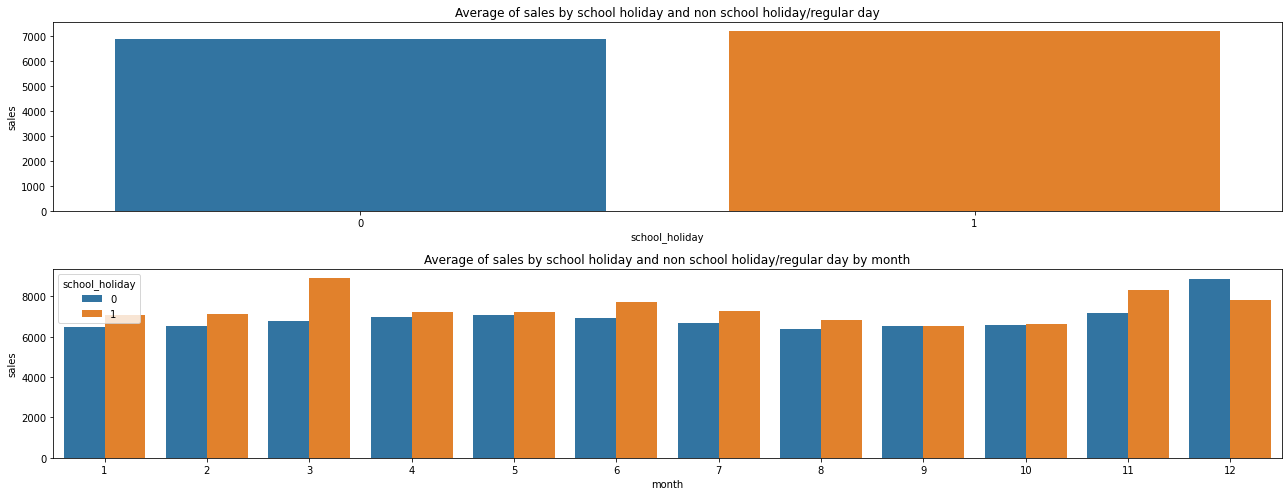

In [158]:
aux1 = df4[["school_holiday","sales"]].groupby("school_holiday").mean().reset_index()

plt.subplot(2,1,1)
sns.barplot(x = "school_holiday", y = "sales", data = aux1).set_title("Average of sales by school holiday and non school holiday/regular day");

aux2 = df4[["month","school_holiday","sales"]].groupby(["month","school_holiday"]).mean().reset_index()

plt.subplot(2,1,2)
sns.barplot(x = "month", y = "sales", data = aux2, hue = "school_holiday").set_title("Average of sales by school holiday and non school holiday/regular day by month");

plt.tight_layout()

## 4.3. Multivariate analysis

### 4.3.1. Numerical Attributes

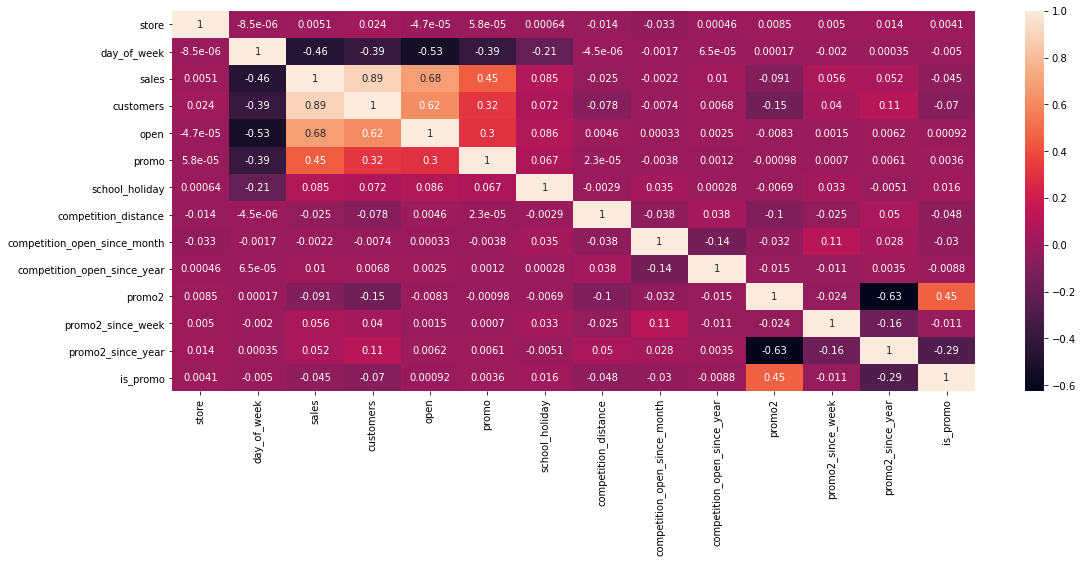

In [159]:
correlation = num_attributes.corr(method = "pearson")
sns.heatmap(correlation, annot = True);

### 4.3.2. Categorical Attributes

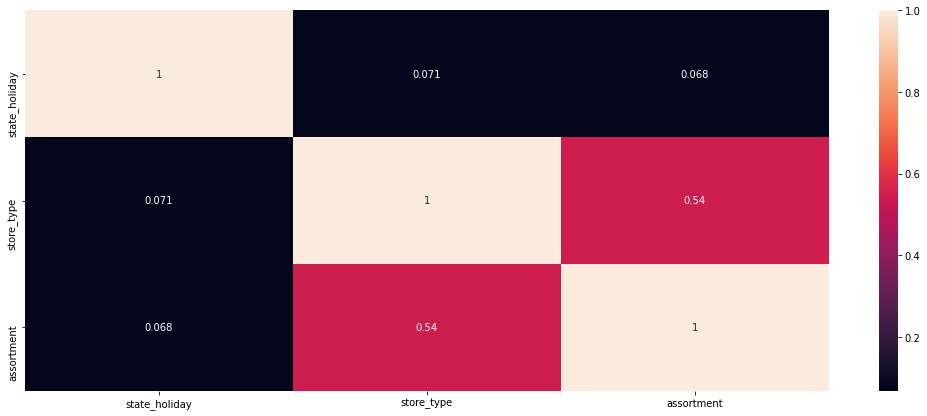

In [160]:
# separating categorical data
a = df4.select_dtypes( include = "object")

# calculating cramer v

a1 = cramer_v(a["state_holiday"], a["state_holiday"])
a2 = cramer_v(a["state_holiday"], a["store_type"])
a3 = cramer_v(a["state_holiday"], a["assortment"])

a4 = cramer_v(a["store_type"], a["state_holiday"])
a5 = cramer_v(a["store_type"], a["store_type"])
a6 = cramer_v(a["store_type"], a["assortment"])

a7 = cramer_v(a["assortment"], a["state_holiday"])
a8 = cramer_v(a["assortment"], a["store_type"])
a9 = cramer_v(a["assortment"], a["assortment"])

# final dataset

d = pd.DataFrame( {"state_holiday": [a1,a2,a3], 
               "store_type": [a4,a5,a6],
               "assortment": [a7,a8,a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot = True);

# 5.0. DATA PREPARATION

In [161]:
df5 = df4.copy()

## 5.1. Normalization

## 5.2. Rescaling

In [162]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5["competition_distance"] = rs.fit_transform(df5[["competition_distance"]].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl','wb'))

# year
df5["year"] = mms.fit_transform(df5[["year"]].values)
pickle.dump(mms, open('parameter/year_scaler.pkl','wb'))

# competition time month
df5["competition_time_month"] = rs.fit_transform(df5[["competition_time_month"]].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl','wb'))

# promo time week
df5["promo_time_week"] = mms.fit_transform(df5[["promo_time_week"]].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl','wb'))

## 5.3. Transformation

### 5.3.1. Encoding

In [163]:
# state_holiday - one hot encoding
df5 = pd.get_dummies( df5, prefix = ["state_holiday"], columns = ["state_holiday"])

# store_type - Label Encoding
le = LabelEncoder()
df5["store_type"] = le.fit_transform(df5["store_type"])
pickle.dump(le,open('parameter/store_type_encoder.pkl','wb'))

# assortment - Ordinal Encoding
assortment_dict = {"basic":1,
                   "extra":2,
                   "extended":3}
df5["assortment"] = df5["assortment"].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [164]:
df5["sales"] = np.log1p(df5["sales"])

### 5.3.3. Nature Transformation

In [165]:
# day of week
df5["day_of_week_sin"] = df5["day_of_week"].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5["day_of_week_cos"] = df5["day_of_week"].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5["month_sin"] = df5["month"].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5["month_cos"] = df5["month"].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5["day_sin"] = df5["day"].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5["day_cos"] = df5["day"].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5["week_of_year_sin"] = df5["week_of_year"].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5["week_of_year_cos"] = df5["week_of_year"].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# 6.0. FEATURE SELECTION

In [166]:
df6 = df5.copy()

## 6.1. Splitting the dataframe into training and testing

In [167]:
# Removing columns that were made derived columns

cols_drop = ["week_of_year","day","month","day_of_week","promo_since","competition_since","year_week"]
df6 = df6.drop(cols_drop, axis = 1)

In [168]:
# For training, all sales made before the last 6 weeks in the dataframe were selected.
# For the test, all sales for the last 6 weeks.

df6[["store","date"]].groupby("store").max().reset_index()["date"][0] - datetime.timedelta(days = 6*7)

# training dataset
X_train = df6[df6["date"] < "2015-06-19"]
Y_train = X_train["sales"]

# test dataset
X_test = df6[df6["date"] >= "2015-06-19"]
Y_test = X_test["sales"]

print("Training Min Date: {}".format( X_train["date"].min()))
print("Training Min Date: {}".format( X_train["date"].max()))

print("\nTraining Min Date: {}".format( X_test["date"].min()))
print("Training Min Date: {}".format( X_test["date"].max()))

Training Min Date: 2013-01-01 00:00:00
Training Min Date: 2015-06-18 00:00:00

Training Min Date: 2015-06-19 00:00:00
Training Min Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [49]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [50]:
# Train and test for boruta
X_train_n = X_train.drop(["date","sales"], axis = 1).values
Y_train_n = Y_train.values.ravel()

# Defining RandomForestRegressor
rf = RandomForestRegressor( n_jobs = -1)

# Defining Boruta
boruta = BorutaPy(rf, n_estimators = "auto", verbose = 2, random_state = 42).fit(X_train_n,Y_train_n)

### 6.2.1. Best features of Boruta

In [51]:
cols_selected = boruta.support_.tolist()

# Best features
X_train_fs = X_train.drop(["date", "sales"], axis = 1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Not selected by Boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3. Manual Feature Selection

In [169]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# Cols to add

feat_to_add = ["date","sales"]
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

#cols_selected_boruta.extend(feat_to_add)